In [1]:
from discopy import Ty, Id, Box, Diagram, Word

# POS TAGS:
s, n, np, adj, tv, iv, vp, rpron = Ty('S'), Ty('N'), Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP'), Ty('RPRON')

# The CFG's production rules are boxes.

R0 = Box('R0', np @ vp, s)
R1 = Box('R1', tv @ np , vp)
R2 = Box('R2', adj @ n, np)
R3 = Box('R3', iv, vp)
R4 = Box('R4', n, np)
R5 = Box('R5', n @ rpron @ vp, np)

prods = [R0, R1, R3, R4, R5]

# WORDS:
nouns = ['Bojack', 'Diane', 'Eve', 'Fiona']
tverbs = ['loves', 'kills']
iverbs = ['sleeps', 'dies']
adjs = []
rprons = ['who']

vocab = [Word(x, n) for x in nouns] + [Word(x, tv) for x in tverbs] + [Word(x, adj) for x in adjs] +\
        [Word(x, iv) for x in iverbs] + [Word(x, rpron) for x in rprons]

Example of a CFG tree:


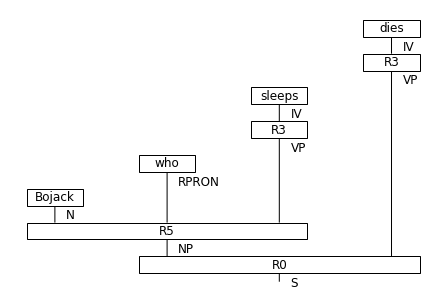

In [2]:
from discopy.grammar import CFG

# Language generation from a CFG:
productions = prods + vocab
cfg = CFG(*productions)
gen = cfg.generate(s, 30, 12, max_iter=1000, remove_duplicates=True)
sentences = []
for sentence in gen:
    sentences += [sentence]
print('Example of a CFG tree:')
sentences[12].draw(aspect='auto')

In [3]:
from discopy.rigid import Cup, Cap, Functor

# From POS tags to Pregroup types:
ob = {n : n, s: s, adj: n @ n.l, tv: n.r @ s @ n.l, iv: n.r @ s, vp:  n.r @ s, np: n, rpron: n.r @ n @ s.l @ n}

# From CFG rules to Pregroup reductions: 
ar = {R0: Cup(n, n.r) @ Id(s), 
      R1: Id(n.r @ s) @ Cup(n.l, n),
      R2: Id(n) @ Cup(n.l, n),
      R3 : Id( n.r @ s),
      R4: Id(n),
      R5: Cup(n, n.r) @ Id(n) @ Diagram.cups(s.l @ n, n.r @ s)}

# Obtain pregroup dictionnary:
new_vocab = [Word(x.name, ob[x.cod]) for x in vocab]
arx = {vocab[i]: new_vocab[i] for i in range(len(vocab))}
ar.update(arx)

T2P = Functor(ob, ar)

Corresponding pregroup reduction:


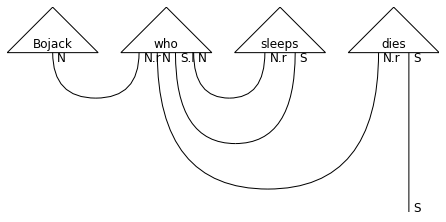

In [4]:
from discopy.grammar import draw
print('Corresponding pregroup reduction:')
draw(T2P(sentences[12]))

In [16]:
from discopy.circuit import Ket, IQPansatz, Euler, CircuitFunctor
from discopy.circuit import sqrt, Circuit, H, CX, SWAP
from discopy import Quiver
import numpy as np

ob = {s: 1, n: 1}
depth = 2

def arity(word):
    return sum(ob[Ty(ty.name)] for ty in word.cod)

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

def ansatz(word):
    if arity(word) == 1:
        return Ket(0) >> Euler(np.random.rand(3))
    elif word.name == 'who':
        return GHZ >> Circuit.id(2) @ Ket(0) @ Circuit.id(1)
    else:
        n = arity(word)
        return Ket(*tuple([0 for i in range(n)])) >> IQPansatz(n, np.random.rand(depth, n - 1))

F = CircuitFunctor(ob, Quiver(ansatz))
circuits = [F(T2P(s)) for s in sentences]

Corresponding circuit:


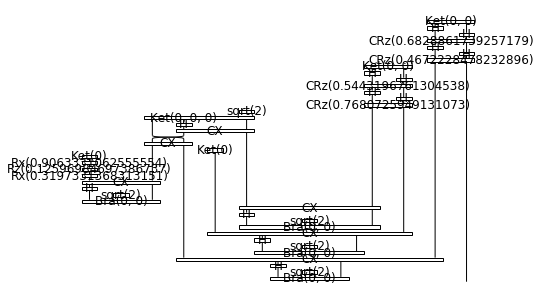

In [17]:
print('Corresponding circuit:')
circuits[12].draw(aspect='auto')

In [18]:
# prepare tket circuits
tket_circuits = [circ.to_tk().measure_all() for circ in circuits]
print('Corresponding tket circuit:')
print(tket_circuits[12])

Corresponding tket circuit:
<tket::Circuit, qubits=9, gates=35>
